<a href="https://colab.research.google.com/github/haoboooo/Temporal-Generalization-of-Sentiment-Analysis-on-Amazon-Reviews/blob/main/video_games/game_AdapterFusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emot
!pip install -U adapter-transformers
!pip install datasets

     |████████████████████████████████| 61 kB 27 kB/s 
     |████████████████████████████████| 3.9 MB 8.9 MB/s 
     |████████████████████████████████| 84 kB 4.2 MB/s 
     |████████████████████████████████| 880 kB 77.4 MB/s 
     |████████████████████████████████| 596 kB 47.5 MB/s 
     |████████████████████████████████| 6.6 MB 6.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=9f3d899382eb947330b5e631eecb3dfd999456e198a96372a9fa7b2f66da1a94
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 346 kB 7.0 MB/s 
     |████████████████████████████████| 1.1 MB 71.9 MB/s 
     |████████████████████████████████| 212 kB 103.7 MB/s 
     |████████████████████████████████|

In [ ]:
import pandas as pd
import numpy as np
import string
import os

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from emot.emo_unicode import EMOTICONS_EMO, UNICODE_EMOJI

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score, f1_score

import torch
from transformers import RobertaTokenizer
import datasets
from datasets import Dataset
from transformers import RobertaConfig, RobertaModelWithHeads
from transformers import TrainingArguments, AdapterTrainer, EvalPrediction

In [ ]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## load game data

In [ ]:
file1 = "./drive/MyDrive/Colab Notebooks/CL/game/97_06.csv"
file2 = "./drive/MyDrive/Colab Notebooks/CL/game/07_12.csv"
file3 = "./drive/MyDrive/Colab Notebooks/CL/game/13_17.csv"
file4 = "./drive/MyDrive/Colab Notebooks/CL/game/18.csv"

In [ ]:
def load_data(file):
  # read csv data and set columns
  df = pd.read_csv(file,usecols=['overall', 'reviewTime','reviewText'])

  # remove the duplicates if any
  df.duplicated('reviewText').sum()
  df.drop_duplicates(subset=['reviewText'],inplace=True)
  
  # remove NaN rows
  df.isnull().sum()
  df.dropna(how='any',axis=0,inplace=True)
  shape = df.shape
  counts = df.overall.value_counts()# labels count

  sns.countplot(df['overall']) # plot bar graph
  fig = plt.gcf() # get current figure
  fig.set_size_inches(5,5) # set the figure size
  plt.title('overall') # add title to the figure

  return df,shape,counts

(95385, 3)
 1.0    69406
-1.0    18035
 0.0     7944
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2006,This game is a good time. Especially if you h...
1,0.0,2005,Don't expect the bells and whistles that you f...
2,1.0,2005,"It is fun to play this game, I really like it...."
3,1.0,2006,Here's the deal with this item: it's fine for ...
4,0.0,2006,We bought this for Christmas for our three kid...


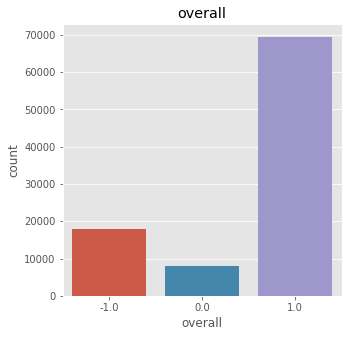

In [ ]:
# load data for 1997 - 2006
df1,shape1,counts1 = load_data(file1)
print(shape1)
print(counts1)
df1.head()

(273501, 3)
 1.0    193149
-1.0     55507
 0.0     24845
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2012,I oredered this for a daughter who is now 33 a...
1,1.0,2010,Well I thought since this idem didn't have any...
2,1.0,2012,Good game. Good graphics. A bit of a learning ...
3,-1.0,2012,"If you buy this game, you will regret it. If ..."
4,1.0,2012,4 Stars because they like it and play it often...


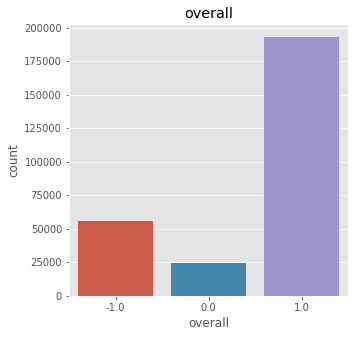

In [ ]:
# load data for 2007 - 2012
df2,shape2,counts2 = load_data(file2)
print(shape2)
print(counts2)
df2.head()

(957163, 3)
 1.0    672584
-1.0    210099
 0.0     74480
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,-1.0,2014,I used to play this game years ago and loved i...
1,0.0,2014,The game itself worked great but the story lin...
2,1.0,2014,I had to learn the hard way after ordering thi...
3,-1.0,2014,The product description should state this clea...
4,1.0,2014,I would recommend this learning game for anyon...


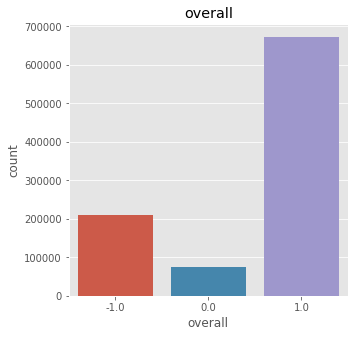

In [ ]:
# load data for 2013 - 2017
df3,shape3,counts3 = load_data(file3)
print(shape3)
print(counts3)
df3.head()

(80396, 3)
 1.0    52744
-1.0    21618
 0.0     6034
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2018,No complaints! Sing your little heart out!
1,1.0,2018,Works great with Xbox 360. I have 2 of these u...
2,1.0,2018,The game was perfect and super clean. Very ple...
3,1.0,2018,It was perfect gift. Got it for Christmas and ...
4,1.0,2018,Lik3d it


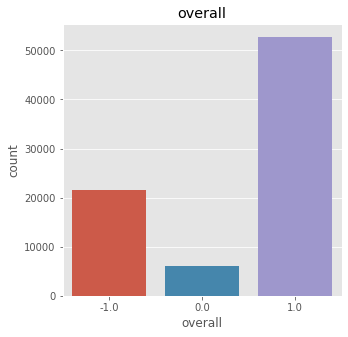

In [ ]:
# load data for 2018
df4,shape4,counts4 = load_data(file4)
print(shape4)
print(counts4)
df4.head()

## Split and Balance train&test

Balance each time period for 
5000 positive，5000 negative，5000 neutral

80%(12000) training and 20%(3000) testing

In [ ]:
def split_balance(df):
  # get data of each class
  groups = df.groupby(df.overall)
  pos = groups.get_group(1)
  neu = groups.get_group(0)
  neg = groups.get_group(-1)

  # shuffle the dataframe
  pos = pos.sample(frac=1.0)
  neu = neu.sample(frac=1.0)
  neg = neg.sample(frac=1.0)

  # split to get train for each class
  train_posdata = pos.iloc[:4000,:]
  train_neudata = neu.iloc[:4000,:]
  train_negdata = neg.iloc[:4000,:]

  # split to get test for each class
  test_posdata = pos.iloc[4000:5000,:]
  test_neudata = neu.iloc[4000:5000,:]
  test_negdata = neg.iloc[4000:5000,:]

  train = pd.concat([train_posdata, train_neudata, train_negdata],sort=False).sample(frac=1.0)
  test = pd.concat([test_posdata, test_neudata, test_negdata],sort=False).sample(frac=1.0)

  return train,test

In [ ]:
# data for 1997 - 2006
df1_train,df1_test = split_balance(df1)

# data for 2007 - 2012
df2_train,df2_test = split_balance(df2)

# data for 2013 - 2017
df3_train,df3_test = split_balance(df3)

# data for 2018
df4_train,df4_test = split_balance(df4)

In [ ]:
df1_train["overall"] = df1_train["overall"].replace(-1,2)
df1_test["overall"] = df1_test["overall"].replace(-1,2)

df2_train["overall"] = df2_train["overall"].replace(-1,2)
df2_test["overall"] = df2_test["overall"].replace(-1,2)

df3_train["overall"] = df3_train["overall"].replace(-1,2)
df3_test["overall"] = df3_test["overall"].replace(-1,2)

df4_train["overall"] = df4_train["overall"].replace(-1,2)
df4_test["overall"] = df4_test["overall"].replace(-1,2)

In [ ]:
df1_train.shape

(12000, 3)

## Text Preprocessing

In [ ]:
# get stopwords from txt
def get_stop_words(txt):
    #read the stop words
    with open(txt,'r') as f:
        stopwords_list=f.readlines()
    for i in range (0,len(stopwords_list)):
        stopwords_list[i]=stopwords_list[i].replace('\n','')
    return stopwords_list

In [ ]:
# Defining my NLTK stop words and my user-defined stop words
stop_words = list(stopwords.words('english'))
alphabets = list(string.ascii_lowercase) # 26 letters with lowercase
user_stop_words = get_stop_words("./drive/MyDrive/Colab Notebooks/CL/stopwords.txt")
stop_words = stop_words+alphabets+user_stop_words
emojis = {**UNICODE_EMOJI,**EMOTICONS_EMO} # full list of emojis unicodes

In [ ]:
def processtext(txt):
  # replace all emojis
  for emo in emojis.keys():
    txt = txt.replace(emo,"EMOJI "+emojis[emo])
  
  txt = txt.replace('\r', '').replace('\n', ' ')
  # remove all html tag
  txt = re.sub("(<.*?>)", "", txt)
  # remove all urls
  txt = re.sub('https?:\/\/\S+','',txt)
  # remove @ references  
  txt = re.sub('@[\w_]+','',txt)
  # remove # hashtags
  txt = re.sub('#\S+','',txt)
  # replace digits with no space
  txt = re.sub(r"\d", '',txt)
  # convert tweet to lower case
  txt = txt.lower()
  # remove all multiple white spaces
  txt = re.sub('[\s]+',' ',txt)
  # remove all punctuations and non-ascii
  txt = re.sub('[\.?!,;:\-\[\]\{\}\(\)\'\"/]','',txt)
  txt = txt.replace('$','').replace('&','')
  # remove whitespace
  txt = txt.strip()

  tokens = word_tokenize(txt)
  filtered_words = [w for w in tokens if w not in stop_words]
  # filtered_words = [w for w in filtered_words if w in word_list]
  return " ".join(filtered_words)

In [ ]:
df1_train["cleanText"] = df1_train["reviewText"].apply(processtext)
df1_test["cleanText"] = df1_test["reviewText"].apply(processtext)

df2_train["cleanText"] = df2_train["reviewText"].apply(processtext)
df2_test["cleanText"] = df2_test["reviewText"].apply(processtext)

df3_train["cleanText"] = df3_train["reviewText"].apply(processtext)
df3_test["cleanText"] = df3_test["reviewText"].apply(processtext)

df4_train["cleanText"] = df4_train["reviewText"].apply(processtext)
df4_test["cleanText"] = df4_test["reviewText"].apply(processtext)

In [ ]:
df1_train.shape

(12000, 4)

## Tokenization

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def encode_batch(batch):
  """Encodes a batch of input data using the model tokenizer."""
  return tokenizer(batch["text"], max_length=128, truncation=True, padding="max_length")

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
def generate_datasetdict(dataframe1,dataframe2):
  text1 = dataframe1.cleanText.values
  text2 = dataframe2.cleanText.values

  label1 = dataframe1.overall.values.astype(np.int32)
  label2 = dataframe2.overall.values.astype(np.int32)

  train_df = pd.DataFrame({"label" : label1,"text" : text1})
  test_df = pd.DataFrame({"label" : label2,"text" : text2})

  train_dataset = Dataset.from_dict(train_df)
  test_dataset = Dataset.from_dict(test_df)
  my_dataset_dict = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})

  # Encode the input data
  dataset = my_dataset_dict.map(encode_batch, batched=True)
  # The transformers model expects the target class column to be named "labels"
  # dataset.rename_column(original_column_name="label", new_column_name="labels")
  # Transform to pytorch tensors and only output the required columns
  dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

  return dataset

In [ ]:
df1_dataset = generate_datasetdict(df1_train,df1_test)
df2_dataset = generate_datasetdict(df2_train,df2_test)
df3_dataset = generate_datasetdict(df3_train,df3_test)
df4_dataset = generate_datasetdict(df4_train,df4_test)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

## Train Adapters

### adapter learning from 1997-2006

In [ ]:
config = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
model = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=config,
)

/usr/local/lib/python3.7/dist-packages/transformers/adapters/models/roberta.py:255: FutureWarning: This class has been renamed to `RobertaAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  FutureWarning,


Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/adapters/models/roberta.py:233: FutureWarning: This class has been renamed to `RobertaAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  FutureWarning,
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModelWithHeads: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModelWithHeads from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModelWithHeads from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

In [ ]:
# Add a new adapter
model.add_adapter("df1")
# Add a matching classification head
model.add_classification_head(
    "reviews",
    num_labels=3,
    id2label={ 0: "neutral", 1: "positive", 2: "negative"}
  )
# Activate the adapter
model.train_adapter("df1")

In [ ]:
training_args = TrainingArguments(
    learning_rate=1e-4,
    num_train_epochs=6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_steps=200,
    output_dir="./training_output",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=False,
)

def compute_accuracy(p: EvalPrediction):
  preds = np.argmax(p.predictions, axis=1)
  return {"acc": (preds == p.label_ids).mean()}

df1_trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=df1_dataset["train"],
    eval_dataset=df1_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
df1_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2250


Step,Training Loss
200,0.959500
400,0.799900
600,0.741500
800,0.755000
1000,0.723000
1200,0.694500
1400,0.691300
1600,0.679000
1800,0.682100
2000,0.681900


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/reviews/head_config.json
Module weights saved in ./training_output/checkpoint-500/reviews/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/df1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/reviews/head_config.json
Module weights saved in ./training_output/checkpoint-1000/reviews/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1500
Configuration saved in ./training_output/checkpoint-1500/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-1500/df1/pytorch_ada

TrainOutput(global_step=2250, training_loss=0.7308875961303711, metrics={'train_runtime': 597.1634, 'train_samples_per_second': 120.57, 'train_steps_per_second': 3.768, 'total_flos': 4818162714624000.0, 'train_loss': 0.7308875961303711, 'epoch': 6.0})

In [ ]:
df1_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.688,
 'eval_loss': 0.7140371203422546,
 'eval_runtime': 12.4858,
 'eval_samples_per_second': 240.273,
 'eval_steps_per_second': 7.529}

In [ ]:
df1_trainer.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.7532462 ,  1.0891151 , -2.1641915 ],
       [ 0.82120883, -0.6637294 , -0.45427924],
       [-0.22263779,  2.481581  , -2.3573875 ],
       ...,
       [ 0.7461357 , -2.7192175 ,  1.942186  ],
       [-0.9496764 ,  2.567347  , -1.7206953 ],
       [ 0.40279695, -0.8018702 ,  0.12683162]], dtype=float32), label_ids=array([2, 0, 1, ..., 2, 1, 0]), metrics={'test_loss': 0.7226447463035583, 'test_acc': 0.6806666666666666, 'test_runtime': 12.7653, 'test_samples_per_second': 235.012, 'test_steps_per_second': 7.364})

In [ ]:
df1_trainer.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[-1.0714022 ,  3.3166664 , -2.2545662 ],
       [-0.4114574 ,  0.3367016 , -0.00341384],
       [-0.26521933,  0.87085044, -0.6768713 ],
       ...,
       [-0.14614539, -1.1957061 ,  1.300216  ],
       [ 0.15358399, -0.35805932, -0.04160236],
       [-0.561238  , -2.6069152 ,  2.9860024 ]], dtype=float32), label_ids=array([1, 0, 1, ..., 2, 0, 2]), metrics={'test_loss': 0.7406497597694397, 'test_acc': 0.6763333333333333, 'test_runtime': 12.5302, 'test_samples_per_second': 239.422, 'test_steps_per_second': 7.502})

In [ ]:
df1_trainer.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.52409136, -1.7022369 ,  0.9726393 ],
       [-0.6813916 ,  1.0435219 , -0.24059312],
       [ 1.1118163 , -2.1122835 ,  0.61698353],
       ...,
       [-0.4389768 ,  2.8451087 , -2.4977734 ],
       [-0.46245515,  2.1439016 , -1.7196485 ],
       [ 0.00642395, -1.0161338 ,  0.69526064]], dtype=float32), label_ids=array([1, 0, 0, ..., 1, 1, 0]), metrics={'test_loss': 0.7485538721084595, 'test_acc': 0.664, 'test_runtime': 12.4545, 'test_samples_per_second': 240.877, 'test_steps_per_second': 7.547})

In [ ]:
model.save_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/game_1", "df1")

Configuration saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/game_1/adapter_config.json
Module weights saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/game_1/pytorch_adapter.bin


In [ ]:
model.delete_adapter('df1')

### adapter learning from 2007-2012

In [ ]:
model.add_adapter("df2")

Adding adapter 'df2'.


In [ ]:
# Activate the adapter
model.train_adapter("df2")

In [ ]:
df2_trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=df2_dataset["train"],
    eval_dataset=df2_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
df2_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2250


Step,Training Loss
200,0.900000
400,0.771600
600,0.767800
800,0.726600
1000,0.728200
1200,0.702400
1400,0.699000
1600,0.689200
1800,0.673600
2000,0.666800


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/reviews/head_config.json
Module weights saved in ./training_output/checkpoint-500/reviews/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/df2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/reviews/head_config.json
Module weights saved in ./training_output/checkpoint-1000/reviews/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1500
Configuration saved in ./training_output/checkpoint-1500/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-1500/df2/pytorch_ada

TrainOutput(global_step=2250, training_loss=0.7250641360812717, metrics={'train_runtime': 596.216, 'train_samples_per_second': 120.762, 'train_steps_per_second': 3.774, 'total_flos': 4818162714624000.0, 'train_loss': 0.7250641360812717, 'epoch': 6.0})

In [ ]:
df2_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.693,
 'eval_loss': 0.7069525718688965,
 'eval_runtime': 12.4432,
 'eval_samples_per_second': 241.095,
 'eval_steps_per_second': 7.554}

In [ ]:
df2_trainer.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.9985352 , -1.4303813 ,  0.7047726 ],
       [ 0.80657995, -0.34379908, -0.23308508],
       [ 0.8326593 , -0.5857812 , -0.13864447],
       ...,
       [ 0.02931352, -0.7862722 ,  0.91664374],
       [-1.0724783 ,  3.391333  , -2.0285246 ],
       [ 0.5617059 , -2.8184588 ,  2.480662  ]], dtype=float32), label_ids=array([1, 1, 0, ..., 1, 1, 2]), metrics={'test_loss': 0.7329215407371521, 'test_acc': 0.6796666666666666, 'test_runtime': 12.4415, 'test_samples_per_second': 241.129, 'test_steps_per_second': 7.555})

In [ ]:
df2_trainer.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[-2.5807983e-01,  3.3638415e+00, -2.7261183e+00],
       [ 2.2115703e-01, -1.4391680e-01, -7.8359120e-02],
       [-1.3448140e-03,  2.3770835e+00, -2.2034814e+00],
       ...,
       [ 3.0377802e-01, -1.4616942e+00,  1.1567008e+00],
       [ 7.5200075e-01, -1.2043986e+00,  2.7167964e-01],
       [-1.6925697e-01, -2.4794896e+00,  2.7946694e+00]], dtype=float32), label_ids=array([1, 0, 1, ..., 2, 0, 2]), metrics={'test_loss': 0.6880096793174744, 'test_acc': 0.6926666666666667, 'test_runtime': 12.443, 'test_samples_per_second': 241.098, 'test_steps_per_second': 7.554})

In [ ]:
df2_trainer.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.43354774, -1.5898199 ,  1.3157257 ],
       [-0.16313945,  0.35577402, -0.0611676 ],
       [ 0.808127  , -1.4787595 ,  0.6520756 ],
       ...,
       [-0.32538688,  3.2236996 , -2.5932581 ],
       [-0.35427496,  2.9178584 , -2.2796752 ],
       [ 0.5857168 , -1.1873085 ,  0.5969138 ]], dtype=float32), label_ids=array([1, 0, 0, ..., 1, 1, 0]), metrics={'test_loss': 0.696072518825531, 'test_acc': 0.6863333333333334, 'test_runtime': 12.4553, 'test_samples_per_second': 240.861, 'test_steps_per_second': 7.547})

In [ ]:
model.save_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/game_2", "df2")

Configuration saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/game_2/adapter_config.json
Module weights saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/game_2/pytorch_adapter.bin


In [ ]:
model.delete_adapter('df2')

### adapter learning from 2013-2017

In [ ]:
model.add_adapter("df3")

Adding adapter 'df3'.


In [ ]:
# Activate the adapter
model.train_adapter("df3")

In [ ]:
df3_trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=df3_dataset["train"],
    eval_dataset=df3_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
df3_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2250


Step,Training Loss
200,0.873800
400,0.776800
600,0.733800
800,0.695500
1000,0.691300
1200,0.691200
1400,0.687700
1600,0.646600
1800,0.649200
2000,0.634100


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df3/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/reviews/head_config.json
Module weights saved in ./training_output/checkpoint-500/reviews/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/df3/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/reviews/head_config.json
Module weights saved in ./training_output/checkpoint-1000/reviews/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1500
Configuration saved in ./training_output/checkpoint-1500/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-1500/df3/pytorch_ada

TrainOutput(global_step=2250, training_loss=0.7016532270643446, metrics={'train_runtime': 604.5355, 'train_samples_per_second': 119.1, 'train_steps_per_second': 3.722, 'total_flos': 4818162714624000.0, 'train_loss': 0.7016532270643446, 'epoch': 6.0})

In [ ]:
df3_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.7196666666666667,
 'eval_loss': 0.6503401398658752,
 'eval_runtime': 12.5932,
 'eval_samples_per_second': 238.223,
 'eval_steps_per_second': 7.464}

In [ ]:
df3_trainer.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 1.5699024 , -1.3542465 , -0.17063233],
       [ 0.8317723 ,  0.13069333, -0.9521997 ],
       [ 0.9684886 , -0.5440687 , -0.43096367],
       ...,
       [-0.01235162, -1.3078074 ,  1.4584569 ],
       [-0.68149877,  2.8318732 , -2.1848674 ],
       [ 1.04445   , -2.7686548 ,  1.6900166 ]], dtype=float32), label_ids=array([1, 1, 0, ..., 1, 1, 2]), metrics={'test_loss': 0.7600263953208923, 'test_acc': 0.6756666666666666, 'test_runtime': 12.4998, 'test_samples_per_second': 240.004, 'test_steps_per_second': 7.52})

In [ ]:
df3_trainer.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 1.3574876 ,  1.575261  , -2.8613584 ],
       [ 1.1235855 , -0.5786787 , -0.46703708],
       [-0.06818726,  2.8366838 , -2.7776728 ],
       ...,
       [ 1.4576787 , -2.4403787 ,  1.0823327 ],
       [-0.76018894,  4.8490176 , -3.7801192 ],
       [ 0.67203104, -1.9411341 ,  1.1208724 ]], dtype=float32), label_ids=array([2, 0, 1, ..., 2, 1, 0]), metrics={'test_loss': 0.7224828004837036, 'test_acc': 0.7003333333333334, 'test_runtime': 12.5035, 'test_samples_per_second': 239.933, 'test_steps_per_second': 7.518})

In [ ]:
df3_trainer.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 1.0938197 , -0.9510882 , -0.19474225],
       [ 0.147908  ,  0.69156826, -0.74750465],
       [ 1.3374331 , -2.1594293 ,  0.73113716],
       ...,
       [ 0.26340586,  2.6465428 , -2.848247  ],
       [-0.18059002,  2.8212392 , -2.51553   ],
       [ 0.7552    , -0.6130352 , -0.2666759 ]], dtype=float32), label_ids=array([1, 0, 0, ..., 1, 1, 0]), metrics={'test_loss': 0.6299405097961426, 'test_acc': 0.723, 'test_runtime': 12.5195, 'test_samples_per_second': 239.627, 'test_steps_per_second': 7.508})

In [ ]:
model.save_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/game_3", "df3")

Configuration saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/game_3/adapter_config.json
Module weights saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/game_3/pytorch_adapter.bin


In [ ]:
model.delete_adapter('df3')

### adapter learning from 2018

In [ ]:
model.add_adapter("df4")

Adding adapter 'df4'.


In [ ]:
# Activate the adapter
model.train_adapter("df4")

In [ ]:
df4_trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=df4_dataset["train"],
    eval_dataset=df4_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
df4_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2250


Step,Training Loss
200,0.821900
400,0.751100
600,0.700300
800,0.697100
1000,0.674500
1200,0.656900
1400,0.647000
1600,0.644200
1800,0.622100
2000,0.611400


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df4/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df4/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/reviews/head_config.json
Module weights saved in ./training_output/checkpoint-500/reviews/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/df4/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/df4/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/reviews/head_config.json
Module weights saved in ./training_output/checkpoint-1000/reviews/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1500
Configuration saved in ./training_output/checkpoint-1500/df4/adapter_config.json
Module weights saved in ./training_output/checkpoint-1500/df4/pytorch_ada

TrainOutput(global_step=2250, training_loss=0.6763883141411675, metrics={'train_runtime': 599.6476, 'train_samples_per_second': 120.071, 'train_steps_per_second': 3.752, 'total_flos': 4818162714624000.0, 'train_loss': 0.6763883141411675, 'epoch': 6.0})

In [ ]:
df4_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.7266666666666667,
 'eval_loss': 0.6228101849555969,
 'eval_runtime': 12.4799,
 'eval_samples_per_second': 240.386,
 'eval_steps_per_second': 7.532}

In [ ]:
df4_trainer.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 1.4181803 , -1.1976849 , -0.1774701 ],
       [ 0.9684238 ,  0.12589602, -1.0973965 ],
       [ 0.6896553 , -0.61586624, -0.07710341],
       ...,
       [-0.0291575 , -0.9544382 ,  1.0794874 ],
       [-0.6150047 ,  2.3468795 , -1.898574  ],
       [ 0.5148941 , -1.944407  ,  1.3892925 ]], dtype=float32), label_ids=array([1, 1, 0, ..., 1, 1, 2]), metrics={'test_loss': 0.7685540914535522, 'test_acc': 0.6736666666666666, 'test_runtime': 12.4943, 'test_samples_per_second': 240.109, 'test_steps_per_second': 7.523})

In [ ]:
df4_trainer.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.75881714,  2.6636386 , -3.4442275 ],
       [ 1.15692   , -0.20532218, -0.94535345],
       [-0.21974298,  2.7791643 , -2.6165254 ],
       ...,
       [ 1.1016597 , -2.1052434 ,  1.0139649 ],
       [-1.1405402 ,  4.9679027 , -3.7727401 ],
       [ 0.678596  , -0.6465822 , -0.15257598]], dtype=float32), label_ids=array([2, 0, 1, ..., 2, 1, 0]), metrics={'test_loss': 0.737520694732666, 'test_acc': 0.6866666666666666, 'test_runtime': 12.4822, 'test_samples_per_second': 240.342, 'test_steps_per_second': 7.531})

In [ ]:
df4_trainer.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[-0.72526026,  4.653679  , -3.992633  ],
       [ 1.4456717 , -0.76140445, -0.82783073],
       [-0.30740303,  3.0603464 , -2.6729834 ],
       ...,
       [ 0.57401717, -2.6805332 ,  1.9546269 ],
       [ 0.4172958 ,  0.48962456, -1.1051198 ],
       [ 0.07271402, -2.7163293 ,  2.7038426 ]], dtype=float32), label_ids=array([1, 0, 1, ..., 2, 0, 2]), metrics={'test_loss': 0.6597708463668823, 'test_acc': 0.7106666666666667, 'test_runtime': 12.5053, 'test_samples_per_second': 239.899, 'test_steps_per_second': 7.517})

In [ ]:
model.save_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/game_4", "df4")

Configuration saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/game_4/adapter_config.json
Module weights saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/game_4/pytorch_adapter.bin


In [ ]:
model.delete_adapter('df4')

## Adapter Fusion

### learn from 1997-2006

In [ ]:
config_fu = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
model_fu = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=config_fu,
)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_v

In [ ]:
from transformers.adapters.composition import Fuse
# Load the pre-trained adapters we want to fuse
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/game_1", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/game_2", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/game_3", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/game_4", with_head=False)

Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_1/adapter_config.json
Adding adapter 'df1'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_1/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_2/adapter_config.json
Adding adapter 'df2'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_2/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_3/adapter_config.json
Adding adapter 'df3'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_3/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_4/adapter_config.json
Adding adapter 'df4'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_4/pytorch_adapter.bin


'df4'

In [ ]:
# Add a fusion layer for all loaded adapters
model_fu.add_adapter_fusion(Fuse("df1", "df2", "df3", "df4"))
model_fu.set_active_adapters(Fuse("df1", "df2", "df3", "df4"))

Adding AdapterFusion 'df1,df2,df3,df4'.
Could not identify a valid prediction head from setup 'Fuse[df1, df2, df3, df4]'.


In [ ]:
# Add a classification head for our target task
model_fu.add_classification_head("fusion", num_labels=3)

Adding head 'fusion' with config {'head_type': 'classification', 'num_labels': 3, 'layers': 2, 'activation_function': 'tanh', 'label2id': {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2}, 'use_pooler': False, 'bias': True}.


In [ ]:
# Unfreeze and activate fusion setup
adapter_setup = Fuse("df1", "df2", "df3", "df4")
model_fu.train_adapter_fusion(adapter_setup)

In [ ]:
fusion_trainer_df1 = AdapterTrainer(
    model=model_fu,
    args=training_args,
    train_dataset=df1_dataset["train"],
    eval_dataset=df1_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
fusion_trainer_df1.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2250


Step,Training Loss
200,0.744400
400,0.704400
600,0.694600
800,0.709400
1000,0.703900
1200,0.672500
1400,0.673700
1600,0.653300
1800,0.667900
2000,0.666300


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df3/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df4/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df4/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df1,df2,df3,df4/adapter_fusion_config.json
Module weights saved in ./training_output/checkpoint-500/df1,df2,df3,df4/pytorch_model_adapter_fusion.bin
Configuration saved in ./training_output/checkpoint-500/fusion/head_config.json
Module weig

TrainOutput(global_step=2250, training_loss=0.6837833675808377, metrics={'train_runtime': 1314.2605, 'train_samples_per_second': 54.784, 'train_steps_per_second': 1.712, 'total_flos': 6141710075904000.0, 'train_loss': 0.6837833675808377, 'epoch': 6.0})

In [ ]:
fusion_trainer_df1.evaluate()

***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.6963333333333334,
 'eval_loss': 0.7107661962509155,
 'eval_runtime': 21.944,
 'eval_samples_per_second': 136.711,
 'eval_steps_per_second': 4.284}

In [ ]:
fusion_trainer_df1.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.92178446,  0.9485904 , -1.8255683 ],
       [ 0.8023669 , -0.5058325 , -0.5966443 ],
       [-0.45684582,  2.769008  , -2.4299452 ],
       ...,
       [ 0.5444067 , -3.217465  ,  1.9885613 ],
       [-0.92991114,  2.5102963 , -1.8009893 ],
       [ 0.22539057, -0.650355  , -0.07495021]], dtype=float32), label_ids=array([2, 0, 1, ..., 2, 1, 0]), metrics={'test_loss': 0.7235249876976013, 'test_acc': 0.686, 'test_runtime': 21.9923, 'test_samples_per_second': 136.411, 'test_steps_per_second': 4.274})

In [ ]:
fusion_trainer_df1.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[-1.0680727 ,  3.2768888 , -2.1687634 ],
       [-0.43621916,  0.1724899 , -0.07911924],
       [-0.4910056 ,  1.0014567 , -0.8852861 ],
       ...,
       [-0.34309268, -1.282451  ,  1.204647  ],
       [ 0.03421253, -0.17588069, -0.12552862],
       [-0.8813786 , -2.8310921 ,  2.9472296 ]], dtype=float32), label_ids=array([1, 0, 1, ..., 2, 0, 2]), metrics={'test_loss': 0.7467454671859741, 'test_acc': 0.6793333333333333, 'test_runtime': 21.9911, 'test_samples_per_second': 136.419, 'test_steps_per_second': 4.274})

In [ ]:
fusion_trainer_df1.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.56216115, -1.7613703 ,  0.77861536],
       [-0.8015397 ,  0.7859268 , -0.3181714 ],
       [ 1.2182431 , -2.309829  ,  0.7923483 ],
       ...,
       [-0.49160552,  2.8494284 , -2.397593  ],
       [-0.42382735,  2.1644566 , -1.7825947 ],
       [-0.07926793, -0.9573597 ,  0.6782275 ]], dtype=float32), label_ids=array([1, 0, 0, ..., 1, 1, 0]), metrics={'test_loss': 0.752469539642334, 'test_acc': 0.668, 'test_runtime': 21.9771, 'test_samples_per_second': 136.506, 'test_steps_per_second': 4.277})

### learn from 2007-2012

In [ ]:
config_fu = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
model_fu = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=config_fu,
)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_v

In [ ]:
from transformers.adapters.composition import Fuse
# Load the pre-trained adapters we want to fuse
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/game_1", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/game_2", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/game_3", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/game_4", with_head=False)

Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_1/adapter_config.json
Adding adapter 'df1'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_1/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_2/adapter_config.json
Adding adapter 'df2'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_2/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_3/adapter_config.json
Adding adapter 'df3'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_3/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_4/adapter_config.json
Adding adapter 'df4'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_4/pytorch_adapter.bin


'df4'

In [ ]:
# Add a fusion layer for all loaded adapters
model_fu.add_adapter_fusion(Fuse("df1", "df2", "df3", "df4"))
model_fu.set_active_adapters(Fuse("df1", "df2", "df3", "df4"))
# Add a classification head for our target task
model_fu.add_classification_head("fusion", num_labels=3)
# Unfreeze and activate fusion setup
adapter_setup = Fuse("df1", "df2", "df3", "df4")
model_fu.train_adapter_fusion(adapter_setup)

Adding AdapterFusion 'df1,df2,df3,df4'.
Could not identify a valid prediction head from setup 'Fuse[df1, df2, df3, df4]'.
Adding head 'fusion' with config {'head_type': 'classification', 'num_labels': 3, 'layers': 2, 'activation_function': 'tanh', 'label2id': {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2}, 'use_pooler': False, 'bias': True}.


In [ ]:
fusion_trainer_df2 = AdapterTrainer(
    model=model_fu,
    args=training_args,
    train_dataset=df2_dataset["train"],
    eval_dataset=df2_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
fusion_trainer_df2.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2250


Step,Training Loss
200,0.760800
400,0.705700
600,0.709700
800,0.690700
1000,0.700300
1200,0.677500
1400,0.687600
1600,0.669100
1800,0.664700
2000,0.661400


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df3/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df4/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df4/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df1,df2,df3,df4/adapter_fusion_config.json
Module weights saved in ./training_output/checkpoint-500/df1,df2,df3,df4/pytorch_model_adapter_fusion.bin
Configuration saved in ./training_output/checkpoint-500/fusion/head_config.json
Module weig

TrainOutput(global_step=2250, training_loss=0.6886213989257812, metrics={'train_runtime': 1295.1207, 'train_samples_per_second': 55.593, 'train_steps_per_second': 1.737, 'total_flos': 6141710075904000.0, 'train_loss': 0.6886213989257812, 'epoch': 6.0})

In [ ]:
fusion_trainer_df2.evaluate()

***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.6923333333333334,
 'eval_loss': 0.709665834903717,
 'eval_runtime': 22.0971,
 'eval_samples_per_second': 135.764,
 'eval_steps_per_second': 4.254}

In [ ]:
fusion_trainer_df2.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.96740305, -2.0377333 ,  0.80560875],
       [ 0.7872119 , -1.1096812 ,  0.06607493],
       [ 0.76499116, -0.995833  , -0.18727805],
       ...,
       [-0.08207886, -0.5850552 ,  0.48652494],
       [-1.3692842 ,  3.0376868 , -2.1972866 ],
       [ 0.2428029 , -2.9313087 ,  2.4783697 ]], dtype=float32), label_ids=array([1, 1, 0, ..., 1, 1, 2]), metrics={'test_loss': 0.7445713877677917, 'test_acc': 0.683, 'test_runtime': 22.0649, 'test_samples_per_second': 135.962, 'test_steps_per_second': 4.26})

In [ ]:
fusion_trainer_df2.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[-0.57340455,  2.9506714 , -2.7286263 ],
       [-0.0674888 ,  0.02617813, -0.0839523 ],
       [-0.24681492,  2.28858   , -2.3231163 ],
       ...,
       [ 0.07607175, -1.4898943 ,  1.271601  ],
       [ 0.76023895, -0.6833213 ,  0.05477468],
       [-0.36181736, -2.8320825 ,  2.7759204 ]], dtype=float32), label_ids=array([1, 0, 1, ..., 2, 0, 2]), metrics={'test_loss': 0.6938517093658447, 'test_acc': 0.694, 'test_runtime': 22.0976, 'test_samples_per_second': 135.761, 'test_steps_per_second': 4.254})

In [ ]:
fusion_trainer_df2.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.48483592, -1.7580241 ,  1.2331239 ],
       [-0.5063687 ,  0.2944181 , -0.13821945],
       [ 0.6978502 , -1.5893486 ,  0.7776186 ],
       ...,
       [-0.7091804 ,  2.9222994 , -2.8061152 ],
       [-0.70756686,  2.5817838 , -2.4321852 ],
       [ 0.541053  , -1.2126688 ,  0.569306  ]], dtype=float32), label_ids=array([1, 0, 0, ..., 1, 1, 0]), metrics={'test_loss': 0.7045297622680664, 'test_acc': 0.683, 'test_runtime': 22.0965, 'test_samples_per_second': 135.768, 'test_steps_per_second': 4.254})

### learn from 2013-2017

In [ ]:
config_fu = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
model_fu = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=config_fu,
)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_v

In [ ]:
from transformers.adapters.composition import Fuse
# Load the pre-trained adapters we want to fuse
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/game_1", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/game_2", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/game_3", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/game_4", with_head=False)

Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_1/adapter_config.json
Adding adapter 'df1'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_1/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_2/adapter_config.json
Adding adapter 'df2'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_2/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_3/adapter_config.json
Adding adapter 'df3'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_3/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_4/adapter_config.json
Adding adapter 'df4'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_4/pytorch_adapter.bin


'df4'

In [ ]:
# Add a fusion layer for all loaded adapters
model_fu.add_adapter_fusion(Fuse("df1", "df2", "df3", "df4"))
model_fu.set_active_adapters(Fuse("df1", "df2", "df3", "df4"))
# Add a classification head for our target task
model_fu.add_classification_head("fusion", num_labels=3)
# Unfreeze and activate fusion setup
adapter_setup = Fuse("df1", "df2", "df3", "df4")
model_fu.train_adapter_fusion(adapter_setup)

Adding AdapterFusion 'df1,df2,df3,df4'.
Could not identify a valid prediction head from setup 'Fuse[df1, df2, df3, df4]'.
Adding head 'fusion' with config {'head_type': 'classification', 'num_labels': 3, 'layers': 2, 'activation_function': 'tanh', 'label2id': {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2}, 'use_pooler': False, 'bias': True}.


In [ ]:
fusion_trainer_df3 = AdapterTrainer(
    model=model_fu,
    args=training_args,
    train_dataset=df3_dataset["train"],
    eval_dataset=df3_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
fusion_trainer_df3.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2250


Step,Training Loss
200,0.728900
400,0.695300
600,0.677800
800,0.653300
1000,0.662300
1200,0.660700
1400,0.655800
1600,0.633400
1800,0.640300
2000,0.626500


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df3/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df4/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df4/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df1,df2,df3,df4/adapter_fusion_config.json
Module weights saved in ./training_output/checkpoint-500/df1,df2,df3,df4/pytorch_model_adapter_fusion.bin
Configuration saved in ./training_output/checkpoint-500/fusion/head_config.json
Module weig

TrainOutput(global_step=2250, training_loss=0.6600328453911676, metrics={'train_runtime': 1294.5268, 'train_samples_per_second': 55.619, 'train_steps_per_second': 1.738, 'total_flos': 6141710075904000.0, 'train_loss': 0.6600328453911676, 'epoch': 6.0})

In [ ]:
fusion_trainer_df3.evaluate()

***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.7226666666666667,
 'eval_loss': 0.6501946449279785,
 'eval_runtime': 22.1299,
 'eval_samples_per_second': 135.563,
 'eval_steps_per_second': 4.248}

In [ ]:
fusion_trainer_df3.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 1.5355173 , -1.4671546 , -0.22494747],
       [ 0.74794793, -0.60106   , -0.42740494],
       [ 1.1271936 , -0.7676283 , -0.69489825],
       ...,
       [-0.07735169, -0.9551734 ,  1.0738988 ],
       [-0.6584227 ,  2.8623896 , -2.327836  ],
       [ 0.99531007, -3.06006   ,  1.8872474 ]], dtype=float32), label_ids=array([1, 1, 0, ..., 1, 1, 2]), metrics={'test_loss': 0.768162190914154, 'test_acc': 0.676, 'test_runtime': 22.0936, 'test_samples_per_second': 135.786, 'test_steps_per_second': 4.255})

In [ ]:
fusion_trainer_df3.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 1.4799005 ,  0.8810807 , -2.4003258 ],
       [ 1.1905631 , -1.085761  , -0.19194458],
       [-0.1889362 ,  2.8202872 , -2.680591  ],
       ...,
       [ 1.4566007 , -2.8252306 ,  1.1132661 ],
       [-0.9082258 ,  4.4958787 , -3.7398295 ],
       [ 0.60316956, -2.407517  ,  1.4628699 ]], dtype=float32), label_ids=array([2, 0, 1, ..., 2, 1, 0]), metrics={'test_loss': 0.7252647876739502, 'test_acc': 0.701, 'test_runtime': 22.0881, 'test_samples_per_second': 135.82, 'test_steps_per_second': 4.256})

In [ ]:
fusion_trainer_df3.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 1.0412611 , -1.1034349 ,  0.19334199],
       [ 0.13337165,  0.47362426, -1.072063  ],
       [ 1.3078111 , -2.223067  ,  0.801909  ],
       ...,
       [-0.01008886,  2.7499118 , -2.965249  ],
       [-0.52995026,  3.0528839 , -2.843357  ],
       [ 1.0266403 , -0.4266497 , -0.4462126 ]], dtype=float32), label_ids=array([1, 0, 0, ..., 1, 1, 0]), metrics={'test_loss': 0.6297531723976135, 'test_acc': 0.725, 'test_runtime': 22.1111, 'test_samples_per_second': 135.679, 'test_steps_per_second': 4.251})

### learn from 2018

In [ ]:
config_fu = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
model_fu = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=config_fu,
)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_v

In [ ]:
from transformers.adapters.composition import Fuse
# Load the pre-trained adapters we want to fuse
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/game_1", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/game_2", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/game_3", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/game_4", with_head=False)

Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_1/adapter_config.json
Adding adapter 'df1'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_1/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_2/adapter_config.json
Adding adapter 'df2'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_2/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_3/adapter_config.json
Adding adapter 'df3'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_3/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_4/adapter_config.json
Adding adapter 'df4'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/game_4/pytorch_adapter.bin


'df4'

In [ ]:
# Add a fusion layer for all loaded adapters
model_fu.add_adapter_fusion(Fuse("df1", "df2", "df3", "df4"))
model_fu.set_active_adapters(Fuse("df1", "df2", "df3", "df4"))
# Add a classification head for our target task
model_fu.add_classification_head("fusion", num_labels=3)
# Unfreeze and activate fusion setup
adapter_setup = Fuse("df1", "df2", "df3", "df4")
model_fu.train_adapter_fusion(adapter_setup)

Adding AdapterFusion 'df1,df2,df3,df4'.
Could not identify a valid prediction head from setup 'Fuse[df1, df2, df3, df4]'.
Adding head 'fusion' with config {'head_type': 'classification', 'num_labels': 3, 'layers': 2, 'activation_function': 'tanh', 'label2id': {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2}, 'use_pooler': False, 'bias': True}.


In [ ]:
fusion_trainer_df4 = AdapterTrainer(
    model=model_fu,
    args=training_args,
    train_dataset=df4_dataset["train"],
    eval_dataset=df4_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
fusion_trainer_df4.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2250


Step,Training Loss
200,0.702000
400,0.687100
600,0.651400
800,0.654500
1000,0.649800
1200,0.628400
1400,0.630700
1600,0.632400
1800,0.608600
2000,0.606500


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df3/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df4/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df4/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df1,df2,df3,df4/adapter_fusion_config.json
Module weights saved in ./training_output/checkpoint-500/df1,df2,df3,df4/pytorch_model_adapter_fusion.bin
Configuration saved in ./training_output/checkpoint-500/fusion/head_config.json
Module weig

TrainOutput(global_step=2250, training_loss=0.6424387164645725, metrics={'train_runtime': 1294.3463, 'train_samples_per_second': 55.627, 'train_steps_per_second': 1.738, 'total_flos': 6141710075904000.0, 'train_loss': 0.6424387164645725, 'epoch': 6.0})

In [ ]:
fusion_trainer_df4.evaluate()

***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.727,
 'eval_loss': 0.6230794787406921,
 'eval_runtime': 22.046,
 'eval_samples_per_second': 136.079,
 'eval_steps_per_second': 4.264}

In [ ]:
fusion_trainer_df4.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 1.3319503 , -1.435354  , -0.07199924],
       [ 0.7455211 , -0.13471691, -0.8874692 ],
       [ 0.7346532 , -1.2011707 ,  0.08619309],
       ...,
       [-0.08701348, -1.0648711 ,  1.0234567 ],
       [-0.82528967,  2.2833483 , -1.6053596 ],
       [ 0.08862095, -2.0809448 ,  1.6485348 ]], dtype=float32), label_ids=array([1, 1, 0, ..., 1, 1, 2]), metrics={'test_loss': 0.7569412589073181, 'test_acc': 0.6746666666666666, 'test_runtime': 22.0281, 'test_samples_per_second': 136.19, 'test_steps_per_second': 4.267})

In [ ]:
fusion_trainer_df4.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.6056523 ,  2.5826716 , -3.2422574 ],
       [ 1.1855537 , -0.41881442, -0.7843238 ],
       [-0.2769553 ,  2.6801717 , -2.4370594 ],
       ...,
       [ 0.93311226, -2.4395869 ,  1.2208152 ],
       [-1.1700937 ,  4.6966476 , -3.5973773 ],
       [ 0.4261287 , -0.7244658 , -0.05103709]], dtype=float32), label_ids=array([2, 0, 1, ..., 2, 1, 0]), metrics={'test_loss': 0.7268901467323303, 'test_acc': 0.6926666666666667, 'test_runtime': 22.0621, 'test_samples_per_second': 135.98, 'test_steps_per_second': 4.261})

In [ ]:
fusion_trainer_df4.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[-0.780533  ,  4.2904816 , -3.540747  ],
       [ 1.4746184 , -0.64516956, -0.84158474],
       [-0.6534791 ,  3.2812624 , -2.7459667 ],
       ...,
       [ 0.3409821 , -2.6011336 ,  2.105875  ],
       [ 0.46093914,  0.3241578 , -0.76361585],
       [-0.10969412, -3.0576613 ,  2.7480054 ]], dtype=float32), label_ids=array([1, 0, 1, ..., 2, 0, 2]), metrics={'test_loss': 0.654715895652771, 'test_acc': 0.714, 'test_runtime': 22.0651, 'test_samples_per_second': 135.961, 'test_steps_per_second': 4.26})